In [393]:
import sys
sys.path.append('/Users/siddarth.chaturvedi/Desktop/source/abmax_git/abmax')
from structs import *
from functions import *
import jax.numpy as jnp
import jax.random as random
import jax
from flax import struct

In [394]:
X_MAX = jnp.array([3]) # 3 lanes
Y_MAX = jnp.array([7]) # 7 length of the road
NUM_CARS = 25
Dt = 1.0  # time step

CAR_AGENT_TYPE = 0
CELL_AGENT_TYPE = 1
KEY = random.PRNGKey(1)
NUM_ROADS = 10
TIME_STEPS = 100

ROAD_CREATE_PARAMS = {
    'X_max': X_MAX,
    'Y_max': Y_MAX,
    'cell_agent_type': CELL_AGENT_TYPE,
    'car_agent_type': CAR_AGENT_TYPE,
    'num_cars': NUM_CARS,
}

In [395]:
def XY_to_cell_id(X:jnp.array, Y:jnp.array, X_max:jnp.array, Y_max:jnp.array):

    X_cond = jnp.logical_and(X[0] < X_max[0], X[0] >= 0)
    Y_cond = jnp.logical_and(Y[0] < Y_max[0], Y[0] >= 0)

    cell_id = jax.lax.cond(jnp.logical_and(X_cond, Y_cond), 
                            lambda _: X + jnp.multiply(Y, X_max), 
                            lambda _: jnp.array([-1]),
                            None)
    return cell_id
jit_XY_to_cell_id = jax.jit(XY_to_cell_id)

def cell_id_to_XY(cell_id, X_max, Y_max):
    X_cond = jnp.logical_and(cell_id[0] < jnp.multiply(X_max, Y_max)[0], cell_id[0] >= 0)
    Y_cond = jnp.logical_and(cell_id[0] < jnp.multiply(X_max, Y_max)[0], cell_id[0] >= 0)
    XY = jax.lax.cond(jnp.logical_and(X_cond, Y_cond), 
                      lambda _: (jnp.mod(cell_id, X_max), jnp.floor_divide(cell_id, X_max)),
                      lambda _: (jnp.array([-1]), jnp.array([-1])),
                      None)
    return XY
jit_cell_id_to_XY = jax.jit(cell_id_to_XY)

In [396]:
@struct.dataclass
class Car(Agent):
    @staticmethod
    def create_agent(type, param, id, active_state, key):
        current_cell_id = jnp.array([-1])
        request_cell_id = jnp.array([-1])
        destination_cell_id = jnp.array([-1])
        wait_time = jnp.array([-1.0])

        state_content = {'current_cell_id': current_cell_id, 'request_cell_id': request_cell_id, 'wait_time': wait_time}
        agent_state = State(content=state_content)

        param_content = {'destination_cell_id': destination_cell_id}
        agent_params = Params(content=param_content)

        return Car(id=id, active_state=active_state, age = 0.0, agent_type=type, params=agent_params, state=agent_state, policy=None, key=key)
    

    @staticmethod
    def add_agent_sci(agents, idx, add_params):
        set_indx = add_params.content['set_indx']
        current_cell_ids = add_params.content['current_cell_ids']

        agent_to_add = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents)

        new_current_cell_id = current_cell_ids[idx]
        new_wait_time = jnp.array([0.0])
        new_request_cell_id = jnp.array([-1])
        
        new_state_content = {'current_cell_id': new_current_cell_id, 
                             'request_cell_id': new_request_cell_id,
                             'wait_time': new_wait_time} 
        new_state = State(content=new_state_content)

        new_destination_cell_id = jnp.array([-1])  # Assuming destination cell id is not provided in this case
        new_param_content = {'destination_cell_id': new_destination_cell_id}
        new_params = Params(content=new_param_content)

        return agent_to_add.replace(state=new_state, params=new_params, age=0.0, active_state = 1)
    
    @staticmethod
    def remove_agent(agent, remove_params):
        new_current_cell_id = jnp.array([-1])
        new_request_cell_id = jnp.array([-1])
        new_wait_time = jnp.array([-1.0])
        new_state_content = {'current_cell_id': new_current_cell_id, 
                             'request_cell_id': new_request_cell_id, 
                             'wait_time': new_wait_time}
        new_state = State(content=new_state_content)
        
        new_destination_cell_id = jnp.array([-1])
        new_param_content = {'destination_cell_id': new_destination_cell_id}
        
        new_params = Params(content=new_param_content)
        return agent.replace(state=new_state, params=new_params, age=0.0, active_state = 0)

    
    @staticmethod
    def step_agent(agent: Agent, input: Signal, step_params: Params):
        
        def step_inactive_agent():
            return agent
        
        def step_active_agent():
            request_cell_id = agent.state.content['request_cell_id']
            current_cell_id = agent.state.content['current_cell_id']
            wait_time = agent.state.content['wait_time']

            dt = step_params.content['dt']

            car_chosen = input.content['car_chosen']
            X_max = step_params.content['X_max']
            Y_max = step_params.content['Y_max']

            # move the car if it is chosen
            new_wait_time, new_current_cell_id = jax.lax.cond(car_chosen, 
                                                              lambda _: (jnp.array([0.0]), request_cell_id),
                                                              lambda _: (wait_time + dt, current_cell_id), 
                                                              None)
            # get the new request cell id
            X, Y = jit_cell_id_to_XY(new_current_cell_id, X_max, Y_max)
            Y_new = Y + 1 # Y increases by 1 i.e. car always wants to go up
        
            key, X_key = random.split(agent.key) # car randomly chooses X_new in the row above

            def X_0(): # if the car is in the 1st column, then it can only go to the 2nd column or stay in the 1st column
                X_new = random.randint(X_key, (1,), minval=0, maxval=2)
                return X_new
        
            def X_1(): # if the car is in the 2nd column, then it can go to the 1st column or stay in the 2nd column or go to the 3rd column
                X_new = random.randint(X_key, (1,), minval=0, maxval=3)
                return X_new
    
            def X_2(): # if the car is in the 3rd column, then it can only go to the 2nd column or stay in the 3rd column
                X_new = random.randint(X_key, (1,), minval=1, maxval=3)
                return X_new
            choices = [X_0, X_1, X_2]
        
            X_new = jax.lax.switch(X[0], choices)

            # now to get the new cell id who has the new X and Y from the cells
            # new_cell_id = cells.id where cells.X = X_new and cells.Y = Y_new
            new_request_cell_id = jit_XY_to_cell_id(X_new, Y_new, step_params.content['X_max'], step_params.content['Y_max'])

            new_state_content = {'current_cell_id': new_current_cell_id, 
                                'request_cell_id': new_request_cell_id, 
                                'wait_time': new_wait_time}
            new_state = State(content=new_state_content)
        
            return agent.replace(state=new_state, key=key, age=agent.age + dt)
        
        return jax.lax.cond(agent.active_state, lambda _: step_active_agent(), 
                            lambda _: step_inactive_agent(), 
                            None)

In [397]:
@struct.dataclass
class Cell(Agent):
    @staticmethod
    def create_agent(type, param, id, active_state, key):
        X_max = param.content['X_max']
        Y_max = param.content['Y_max']
        (X, Y) = jit_cell_id_to_XY(jnp.array([id]), X_max, Y_max)
        
        entry = jnp.array([id < 3], dtype=jnp.int32) # first 3 are entry cells
        num_rows = Y_max[0]

        exit = jnp.array([id >= num_rows * 3 - 3], dtype=jnp.int32) # exit cell
        
        def left_priority_mask(): # for left lane cells
            return jnp.array([0, 3, 2, 0, 0, 0, 0, 0], dtype=jnp.int32)
        def right_priority_mask(): # for right lane cells
            return jnp.array([2, 3, 0, 0, 0, 0, 0, 0], dtype=jnp.int32)
        def center_priority_mask(): # for center lane cells
            return jnp.array([2, 3, 1, 0, 0, 0, 0, 0], dtype=jnp.int32)
        choices = [left_priority_mask, center_priority_mask, right_priority_mask]
        priority_mask =  jax.lax.switch(X[0], choices)

        

        agent_params_content = { "X": X, "Y": Y, "entry": entry, "exit": exit, "priority_mask": priority_mask}
        agent_params = Params(content=agent_params_content)

        car_id = jnp.array([-1]) # id of the cars in the cell in the beginning
        num_cars = jnp.array([0]) # number of cars in the cell
        light = jnp.array([1]) # light state, 0 for red, 1 for green
        key,subkey = random.split(key) # split the key for the agent
        light_counter = jax.random.randint(subkey, (1,), minval=5, maxval=10) # random light counter to simulate light change

        agent_state_content = {"car_id": car_id, "num_cars": num_cars, "light": light, "light_counter": light_counter}
        agent_state = State(content=agent_state_content)

        return Cell( id = id, active_state=active_state, age = 0.0, agent_type= type, params= agent_params, state= agent_state, policy = None, key = key)

    @staticmethod
    def set_entry_cell(agents, idx, set_params):
        set_indx = set_params.content['set_indx']
        agent_to_set = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents)
        
        num_cars_new = agent_to_set.state.content['num_cars']+1
        car_id_to_add = jnp.array([set_params.content['car_id'][idx]]) # be careful to preserve the shape to (1,)
        light = agent_to_set.state.content['light'] # keep the light state same as before
        light_counter = agent_to_set.state.content['light_counter'] # keep the light counter same as before

        new_state_content = {'car_id': car_id_to_add, 'num_cars': num_cars_new, 'light': light, 'light_counter': light_counter}
        new_state = State(content=new_state_content)

        return agent_to_set.replace(state=new_state)
    
    @staticmethod
    def step_agent(cell:Agent, input: Signal, step_params: Params):
        # Getting variables from step_params and state/params content
        cars = step_params.content['cars']
        cells = step_params.content['cells']
        X_max = step_params.content['X_max']
        Y_max = step_params.content['Y_max']

        num_cars = cell.state.content['num_cars']
        car_id = cell.state.content['car_id']

        priority_mask = cell.params.content['priority_mask']

        light = cell.state.content['light']
        light_counter = cell.state.content['light_counter']

        car_indx = jnp.argmax(jnp.where(car_id[0]==cars.id, 1, 0))
        car = jax.tree_util.tree_map(lambda x: x[car_indx], cars)
        car_cell_id = car.state.content['current_cell_id'] # In what Cell the Car in this Cell is according to them

        # step 1: Sender: If the car reflects that it has moved on, then empty the cell
        cond = jnp.logical_and(car.active_state, car_cell_id[0] == cell.id)
        cond = jnp.logical_and(cond, car_id[0] != -1) # Cell has an active Car in it
        new_car_id, new_num_cars = jax.lax.cond(cond, lambda _: (jnp.array([car.id]), num_cars), lambda _: (jnp.array([-1]), num_cars - 1), None)
        new_num_cars = jnp.clip(new_num_cars, 0, 1) 

        # step 2: Receiver: If the cell is empty and is a request cell for cars then ask the car to move
        cells_around_me_d_XY = jnp.array([[[-1], [-1]], [[0], [-1]], [[1], [-1]], [[-1], [0]], [[1], [0]], [[-1], [1]], [[0], [1]], [[1], [1]]])
        cells_around_me_XY = jnp.array([cell.params.content['X'], cell.params.content['Y']]) + cells_around_me_d_XY
        cells_id_around_me = jax.vmap(jit_XY_to_cell_id, in_axes=(0, 0, None, None))(cells_around_me_XY[:, 0], cells_around_me_XY[:, 1], X_max, Y_max)

        def get_car_ids(cell_id):
            # If the cell id is valid (not -1), take its car_id. If not return an invalid value: jnp.array([-1])
            cell_id = cell_id[0]
            return jax.lax.cond(cell_id >= 0, 
                        lambda _: cells.state.content['car_id'][cell_id],
                        lambda _: jnp.array([-1]),
                        None)
        car_ids_around_me = jax.vmap(get_car_ids)(cells_id_around_me)

        def get_car_requested_cell_ids_wait_times(car_id):
            # If the Car id is valid (not -1), return its requested_cell_id and wait_time. If not return invalid values: (jnp.array([-1]) jnp.array([-1.0]))
            car_indx = jnp.argmax(jnp.where(car_id[0] == cars.id, 1, 0))
            return jax.lax.cond(car_id[0] >= 0,
                            lambda _: (cars.state.content['request_cell_id'][car_indx], cars.state.content['wait_time'][car_indx]), # get the request cell id and wait time
                            lambda _: (jnp.array([-1]), jnp.array([-1.0])), # if the car id is -1, then return -1, -1.0
                            None)
        car_requested_cell_ids, car_wait_times = jax.vmap(get_car_requested_cell_ids_wait_times)(car_ids_around_me)

        car_come_to_me = jnp.where(car_requested_cell_ids == cell.id, 1, 0).reshape(-1) #cars that want to come to this Cell
        car_priority_lane = jnp.multiply(car_come_to_me, priority_mask) # multiply by the lane priority mask to get lane preference
        #car_priority_wt_time = jnp.multiply(car_priority_lane, car_wait_times.reshape(-1)) # multiply by the wait time to get preference

        max_value = jnp.max(car_priority_lane)
        preferred_car_id = jax.lax.cond(max_value <= 0,
                                            lambda _: jnp.array([-1]), # if no car wants to come, then return -1
                                            lambda _: car_ids_around_me[jnp.argmax(car_priority_lane)],
                                            None)

        new_car_id, new_num_cars = jax.lax.cond(jnp.logical_and(new_num_cars[0] < 1, preferred_car_id[0] >= 0),
                                                    lambda _: (preferred_car_id, new_num_cars + 1),
                                                    lambda _: (new_car_id, new_num_cars), None)
        
        light_counter = light_counter - 1
        key, subkey = random.split(cell.key)
        light, light_counter = jax.lax.cond(light_counter[0] <= 0,
                                                lambda _: (1 - light, jax.random.randint(subkey, (1,), minval=5, maxval=10)), # change light and reset counter
                                                lambda _: (light, light_counter), None)

        new_state_content = {'car_id': new_car_id, 'num_cars': new_num_cars, 'light': light, 'light_counter': light_counter}
        new_state = State(content=new_state_content)
        
        return cell.replace(state=new_state, key=key)
    
    @staticmethod
    def send_car(cell:Agent, input: Signal, step_params: Params):
        cars = step_params.content['cars']

        num_cars = cell.state.content['num_cars']
        car_id = cell.state.content['car_id']
        light = cell.state.content['light']
        light_counter = cell.state.content['light_counter']

        car_indx = jnp.argmax(jnp.where(car_id[0]==cars.id, 1, 0))
        car = jax.tree_util.tree_map(lambda x: x[car_indx], cars)
        car_cell_id = car.state.content['current_cell_id']

        cond = jnp.logical_and(car.active_state, car_cell_id[0] == cell.id)
        cond = jnp.logical_and(cond, car_id[0] != -1) # Cell has an active Car in it

        new_car_id, new_num_cars = jax.lax.cond(cond, lambda _: (jnp.array([car.id]), num_cars), lambda _: (jnp.array([-1]), num_cars - 1), None)
        new_num_cars = jnp.clip(new_num_cars, 0, 1)

        new_state_content = {'car_id': new_car_id, 'num_cars': new_num_cars, 'light': light, 'light_counter': light_counter}
        new_state = State(content=new_state_content)

        return cell.replace(state=new_state)

    @staticmethod
    def recieve_car(cell:Agent, input: Signal, step_params: Params):
        cars = step_params.content['cars']
        cells = step_params.content['cells']
        X_max = step_params.content['X_max']
        Y_max = step_params.content['Y_max']

        priority_mask = cell.params.content['priority_mask']
        num_cars = cell.state.content['num_cars']
        car_id = cell.state.content['car_id']

        light = cell.state.content['light']
        light_counter = cell.state.content['light_counter']

        cells_around_me_d_XY = jnp.array([[[-1], [-1]], [[0], [-1]], [[1], [-1]], [[-1], [0]], [[1], [0]], [[-1], [1]], [[0], [1]], [[1], [1]]])
        cells_around_me_XY = jnp.array([cell.params.content['X'], cell.params.content['Y']]) + cells_around_me_d_XY
        cells_id_around_me = jax.vmap(jit_XY_to_cell_id, in_axes=(0, 0, None, None))(cells_around_me_XY[:, 0], cells_around_me_XY[:, 1], X_max, Y_max)

        def get_car_ids(cell_id):
            # If the cell id is valid (not -1), take its car_id. If not return an invalid value: jnp.array([-1])
            cell_id = cell_id[0]
            return jax.lax.cond(cell_id >= 0, 
                        lambda _: cells.state.content['car_id'][cell_id],
                        lambda _: jnp.array([-1]),
                        None)
        car_ids_around_me = jax.vmap(get_car_ids)(cells_id_around_me)

        def get_car_requested_cell_ids_wait_times(car_id):
            # If the Car id is valid (not -1), return its requested_cell_id and wait_time. If not return invalid values: (jnp.array([-1]) jnp.array([-1.0]))
            car_indx = jnp.argmax(jnp.where(car_id[0] == cars.id, 1, 0))
            return jax.lax.cond(car_id[0] >= 0,
                            lambda _: (cars.state.content['request_cell_id'][car_indx], cars.state.content['wait_time'][car_indx]), # get the request cell id and wait time
                            lambda _: (jnp.array([-1]), jnp.array([-1.0])), # if the car id is -1, then return -1, -1.0
                            None)
        
        car_requested_cell_ids, car_wait_times = jax.vmap(get_car_requested_cell_ids_wait_times)(car_ids_around_me)

        car_come_to_me = jnp.where(car_requested_cell_ids == cell.id, 1, 0).reshape(-1) #cars that want to come to this Cell
        car_priority_lane = jnp.multiply(car_come_to_me, priority_mask) # multiply by the lane priority mask to get lane preference
        #car_priority_wt_time = jnp.multiply(car_priority_lane, car_wait_times.reshape(-1)) # multiply by the wait time to get preference

        max_value = jnp.max(car_priority_lane)
        preferred_car_id = jax.lax.cond(max_value <= 0,
                                            lambda _: jnp.array([-1]), # if no car wants to come, then return -1
                                            lambda _: car_ids_around_me[jnp.argmax(car_priority_lane)],
                                            None)

        new_car_id, new_num_cars = jax.lax.cond(jnp.logical_and(num_cars[0] < 1, preferred_car_id[0] >= 0),
                                                    lambda _: (preferred_car_id, num_cars + 1),
                                                    lambda _: (car_id, num_cars), None)
        light_counter = light_counter - 1
        key, subkey = random.split(cell.key)
        light, light_counter = jax.lax.cond(light_counter[0] <= 0,
                                                lambda _: (1 - light, jax.random.randint(subkey, (1,), minval=5, maxval=10)), # change light and reset counter
                                                lambda _: (light, light_counter), None)

        new_state_content = {'car_id': new_car_id, 'num_cars': new_num_cars, 'light': light, 'light_counter': light_counter}

        new_state = State(content=new_state_content)

        return cell.replace(state=new_state, key=key)
    

In [398]:
@struct.dataclass
class Road:
    cells: Set
    cars: Set
    key: random.PRNGKey


In [399]:
def is_move(cars: Agent, cells: Agent):
    #check if the car is chosen by the cell
    def is_chosen(car: Agent, cells: Agent):
        requested_cell_id = car.state.content['request_cell_id']
        current_cell_id = car.state.content['current_cell_id']
        exit = cells.params.content['exit'][current_cell_id[0]][0]  # Check if the current cell is an exit cell
        chosen_car_id = cells.state.content['car_id'][requested_cell_id][0]
        

        chosen = jax.lax.cond(jnp.logical_and(requested_cell_id[0] >= 0, exit==0), 
                              lambda _: car.id == chosen_car_id[0], # Only to move if the cell chose the car id and the cell is not an exit cell
                              lambda _: False, # If no cell has been requested yet, car is not to move.
                              None)
        return chosen

    chosen_arr = jax.vmap(is_chosen, in_axes=(0, None))(cars, cells)
    return chosen_arr
jit_is_move = jax.jit(is_move)

def is_remove(cars: Agent, cells:Agent):
    # if the car is at the exit cell, and the light is green(1), then it can be removed.
    def for_a_car(car):
        current_cell_id = car.state.content['current_cell_id']
        cond = jnp.logical_and(cells.params.content['exit'][current_cell_id[0]][0] == 1, cells.state.content['light'][current_cell_id[0]][0] == 1)
        cond = jnp.logical_and(cond, car.active_state) # car is active
        remove_flag = jax.lax.cond(cond,
                                  lambda _: 1, # car can be removed
                                  lambda _: 0, # car cannot be removed
                              None)
        return remove_flag
    remove_flags = jax.vmap(for_a_car)(cars)
    return remove_flags
jit_is_remove = jax.jit(is_remove)


def select_empty_slots(cars:Agent, select_params:Params):
    return jnp.logical_not(cars.active_state)  # Selects the slots where cars are not active

def spawn_cars(road:Road, key: jax.random.PRNGKey):
    cells = road.cells.agents

    entry_cell_ids = jnp.array([0,1,2])
    key, *subkey = random.split(key,3)

    num_cars_add = jax.random.randint(subkey[0], (1,), minval=1, maxval=4)[0]  # Randomly choose how many cars to spawn
    

    shuffled_entry_cell_ids = jax.random.permutation(subkey[1], entry_cell_ids)
    num_cars_shuffled = jnp.take(cells.state.content['num_cars'], shuffled_entry_cell_ids)
    is_cell_empty = jnp.where(num_cars_shuffled == 0, 1, 0)

    sorted_car_indexes  = jnp.argsort(-1*is_cell_empty.reshape(-1))  # Sort the car indexes based on the number of cars in the entry cells
    sorted_shuffled_entry_cell_ids = jnp.take(shuffled_entry_cell_ids, sorted_car_indexes)  # Get the sorted entry cell ids 

    num_empty_cells = jnp.sum(is_cell_empty)  # Calculate the number of empty cells in the entry cells
    num_cars_add = jnp.minimum(num_cars_add, num_empty_cells)  # Ensure we don't add more cars than empty cells

    _, inactive_car_index = jit_select_agents(select_empty_slots, None, road.cars)

    #define cell set params using set_sci method
    cell_set_params = Params(content={'set_indx': sorted_shuffled_entry_cell_ids, 'car_id': inactive_car_index})

    #define car add params based on the set_sci method
    car_add_params = Params(content={'set_indx': inactive_car_index, 'current_cell_ids': sorted_shuffled_entry_cell_ids})

    return cell_set_params, car_add_params, num_cars_add, key

jit_spawn_cars = jax.jit(spawn_cars)


In [400]:
def create_road(params, key, road_id):
    key, *create_keys = random.split(key, 3)
    
    x_max = params['X_max']
    y_max = params['Y_max']

    # step 1: create the cells
    cell_agent_type = params['cell_agent_type']
    num_cells = x_max[0] * y_max[0]
    cell_create_params = Params(content={'X_max': jnp.tile(x_max, (num_cells, 1)), 'Y_max': jnp.tile(y_max, (num_cells, 1))})
    
    cells = create_agents(agent=Cell, params=cell_create_params, num_agents=num_cells, num_active_agents=num_cells, agent_type=cell_agent_type, key=create_keys[0])
    cells_Set = Set(num_agents=num_cells, num_active_agents=num_cells, agents=cells, id = road_id, set_type=cell_agent_type, params=None, key=None, state=None, policy=None)


    # step 2: create the cars
    car_create_params = None
    num_cars = params['num_cars']
    car_agent_type = params['car_agent_type']
    
    cars = create_agents(agent=Car, params=car_create_params, num_agents=num_cars, num_active_agents=0, agent_type=car_agent_type, key=create_keys[1])
    cars_Set = Set(num_agents=num_cars, num_active_agents=0, agents=cars, id=road_id, set_type=car_agent_type, params=None, key=None, state=None, policy=None)

    return Road(cells=cells_Set, cars=cars_Set, key=key)

def step(road, _t):
    cars_Set = road.cars
    cells_Set = road.cells
    key = road.key

    #step 0 spawn new cars
    cell_set_params, car_add_params, num_cars_add, key = jit_spawn_cars(road, key)
    cars_Set = jit_set_agents_sci(Car.add_agent_sci, car_add_params, num_cars_add, cars_Set)
    cells_Set = jit_set_agents_sci(Cell.set_entry_cell, cell_set_params, num_cars_add, cells_Set)
    
    #step 1 remove cars when the signal is green and the car is at the exit cell
    remove_car_mask = jit_is_remove(cars_Set.agents, cells_Set.agents)
    remove_cars_params = Params(content={'set_mask': remove_car_mask})
    cars_Set = jit_set_agents_mask(Car.remove_agent, num_agents=-1, mask_params=remove_cars_params, set_params=None, set=cars_Set)

    #step 2 recieve the cars
    recieve_step_params = Params(content={'cars': cars_Set.agents, 'cells': cells_Set.agents, 'X_max': X_MAX, 'Y_max': Y_MAX})
    cells_Set = jit_step_agents(Cell.recieve_car, recieve_step_params, None, cells_Set)

    #step 3 step the cars
    step_params = Params(content={'dt': Dt, 'X_max': X_MAX, 'Y_max': Y_MAX})
    car_chosen_input = jit_is_move(cars_Set.agents, cells_Set.agents)
    
    step_input = Signal(content={'car_chosen': car_chosen_input})
    cars_Set = jit_step_agents(Car.step_agent, step_params, step_input, cars_Set)

    #step 4 send the cars
    send_step_params = Params(content={'cars': cars_Set.agents})
    cells_Set = jit_step_agents(Cell.send_car, send_step_params, None, cells_Set)


    return road.replace(cells=cells_Set, cars=cars_Set, key=key), cars_Set.num_active_agents
jit_step = jax.jit(step)

def run_scan(road, ts):
    road, num_cars = jax.lax.scan(jit_step, road, ts)
    return road, num_cars

jit_vmap_run_scan = jax.jit(jax.vmap(run_scan, in_axes=(0, None)))

def run_main(params, key, num_roads=NUM_ROADS, time_steps=TIME_STEPS):
    key, *road_keys = jax.random.split(key, num_roads + 1)
    road_keys = jnp.array(road_keys)
    road_ids = jnp.arange(num_roads)
    
    roads = jax.vmap(create_road, in_axes=(None, 0, 0))(params, road_keys, road_ids)

    ts = jnp.arange(time_steps)
    roads, num_cars = jit_vmap_run_scan(roads, ts)
    return num_cars
    


In [401]:
num_cars = run_main(ROAD_CREATE_PARAMS, KEY, NUM_ROADS, TIME_STEPS)

In [402]:
print(num_cars.shape)

(10, 100)


In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)


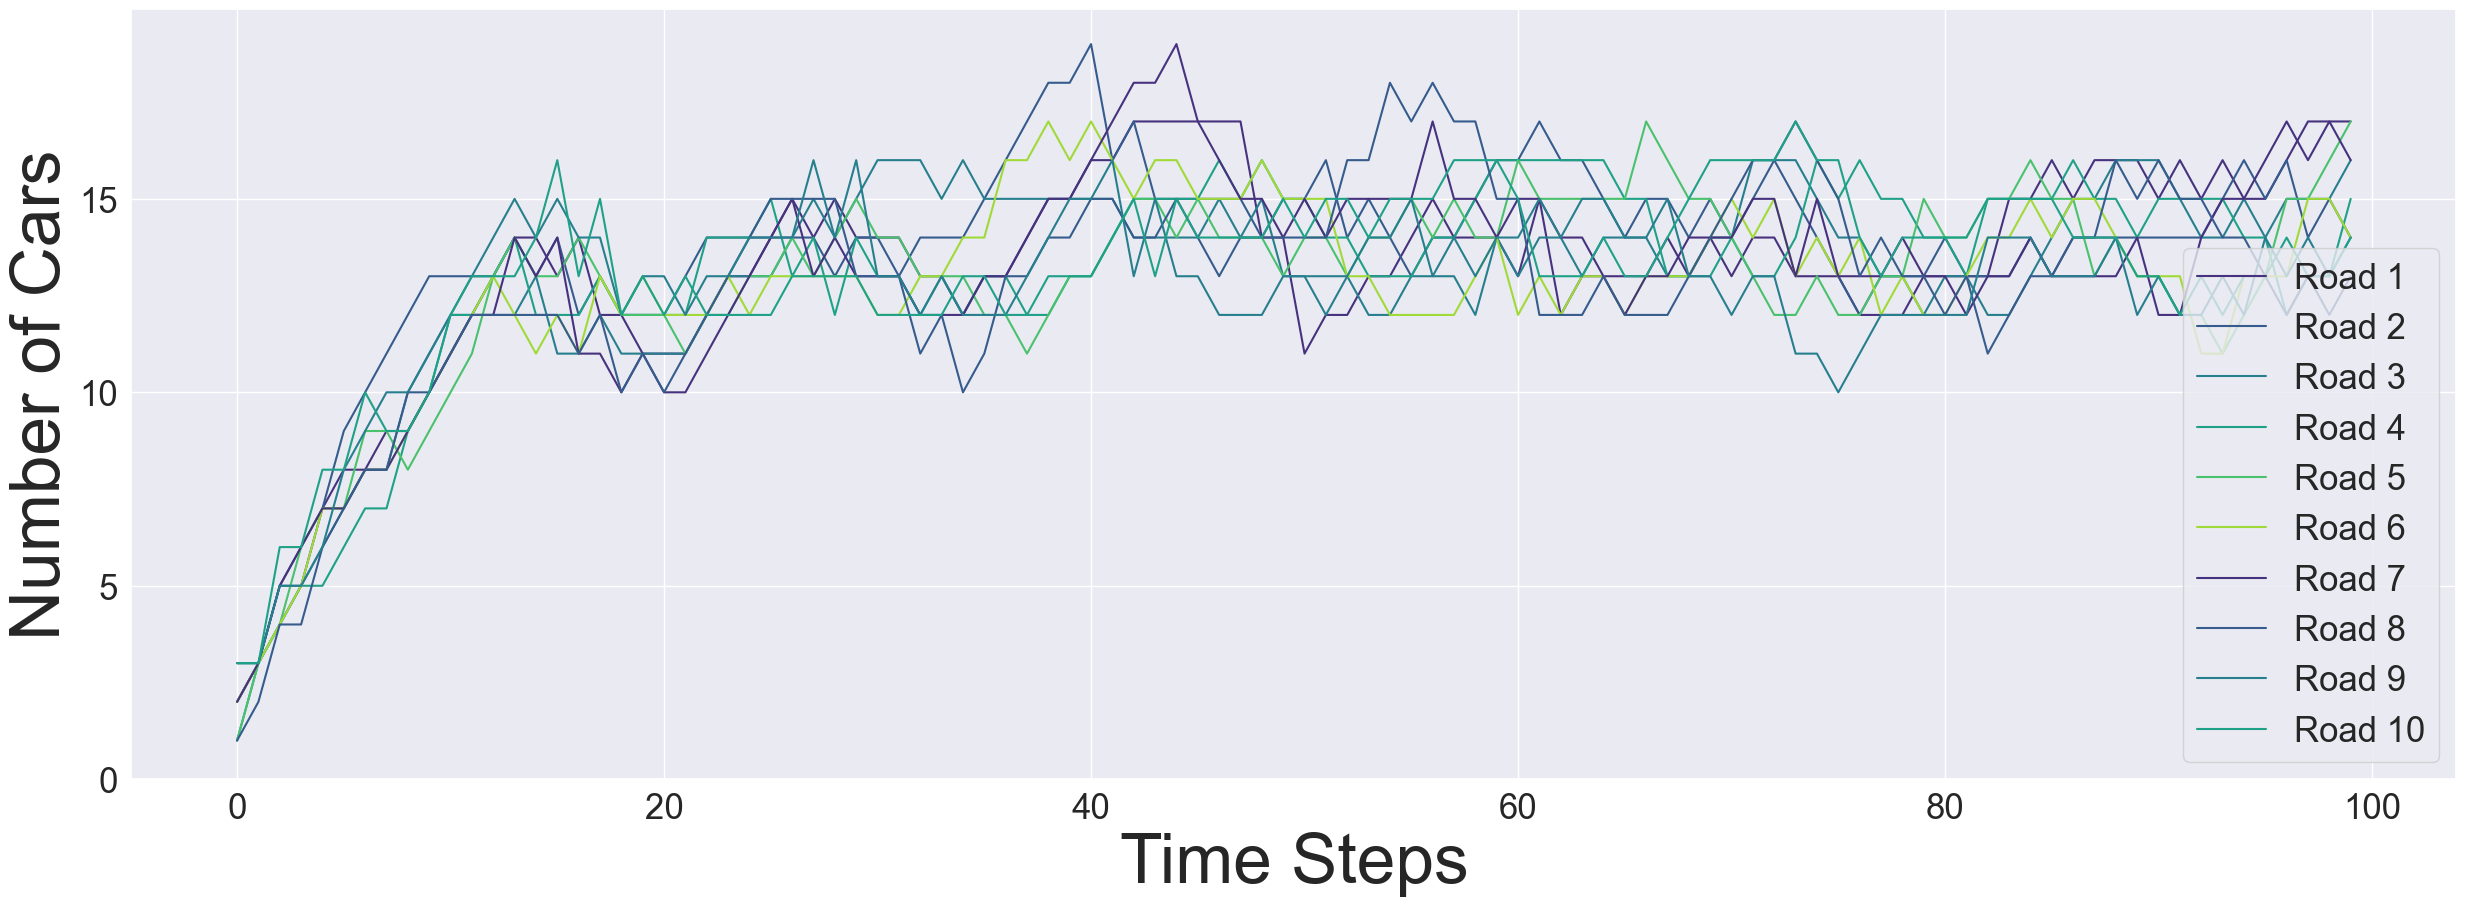

In [407]:
fig, ax = plt.subplots(figsize=(30,10))
for i in range(NUM_ROADS):
    ax.plot(num_cars[i,:], label=f'Road {i+1}')
ax.set_xlabel('Time Steps', fontsize=50)
#show only integers on Y ticks multiple of 5
ax.set_yticks(jnp.arange(0, jnp.max(num_cars) + 1, 5))
ax.set_ylabel('Number of Cars', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25)
plt.savefig('./traffic_jam.svg', bbox_inches='tight')
plt.show()

In [346]:
num_roads =10
key, *road_keys = random.split(KEY, num_roads+1)
road_keys = jnp.array(road_keys)
road_ids = jnp.arange(num_roads)
roads = jax.vmap(create_road, in_axes=(None, 0, 0))(ROAD_CREATE_PARAMS, road_keys, road_ids)
print("entry cell for all roads created", roads.cells.agents.params.content['entry'].reshape(num_roads, -1))
print("exit cell for all roads created", roads.cells.agents.params.content['exit'].reshape(num_roads, -1))

entry cell for all roads created [[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
exit cell for all roads created [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]]


In [347]:
road_0 = jax.tree_util.tree_map(lambda x: x[0], roads)


In [367]:
print("car ids in cells", road_0.cells.agents.state.content['car_id'].reshape(-1))
print("num cars in cells", road_0.cells.agents.state.content['num_cars'].reshape(-1))
print("cell ids of cars", road_0.cars.agents.state.content['current_cell_id'].reshape(-1))
print("request cell ids of cars", road_0.cars.agents.state.content['request_cell_id'].reshape(-1))
print("\n")

road_0, num_cars_added = step(road_0, 0)

print("After 1 step:")
print("num cars added", num_cars_added)
print("car ids in cells", road_0.cells.agents.state.content['car_id'].reshape(-1))
print("num cars in cells", road_0.cells.agents.state.content['num_cars'].reshape(-1))
print("cell ids of cars", road_0.cars.agents.state.content['current_cell_id'].reshape(-1))
print("request cell ids of cars", road_0.cars.agents.state.content['request_cell_id'].reshape(-1))


car ids in cells [11  2  3 13 -1  4 -1 12 -1 -1 14 10  1  8 -1 -1 -1  6 -1  9 -1]
num cars in cells [1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0]
cell ids of cars [-1 12  1  2  5 -1 17 -1 13 19 11  0  7  3 10 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
request cell ids of cars [-1 15  3  5  7 -1 19 -1 16 -1 14  3 10  7 14 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]


After 1 step:
num cars added 0
car ids in cells [11  2  3 13 -1  4 -1 12 -1 -1 14 -1 -1 -1 10  1  8  6 -1 -1 -1]
num cars in cells [1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0]
cell ids of cars [-1 15  1  2  5 -1 17 -1 16 -1 14  0  7  3 10 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
request cell ids of cars [-1 19  5  4  8 -1 19 -1 19 -1 17  4 10  6 12 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
